## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'efficientnet-exp002'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b7'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 32 # 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

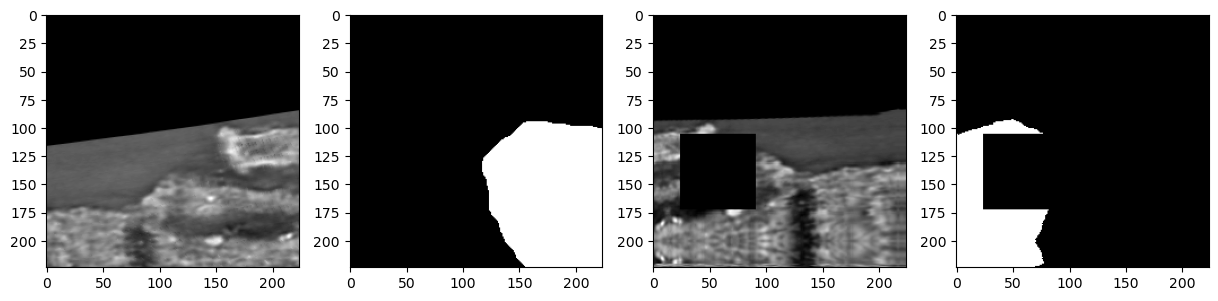

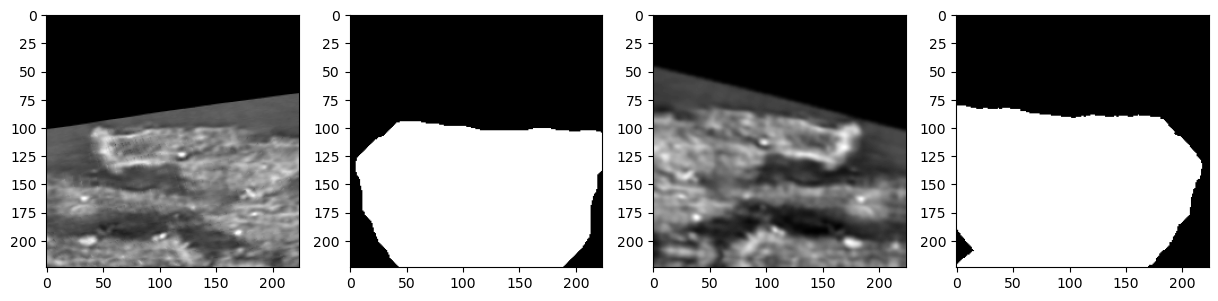

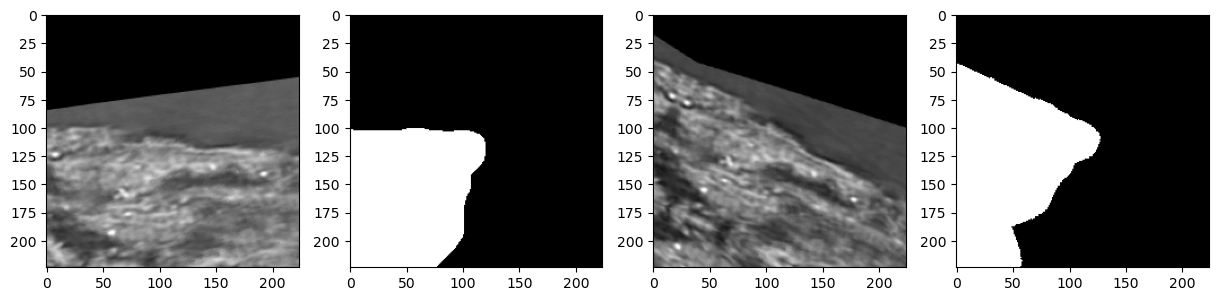

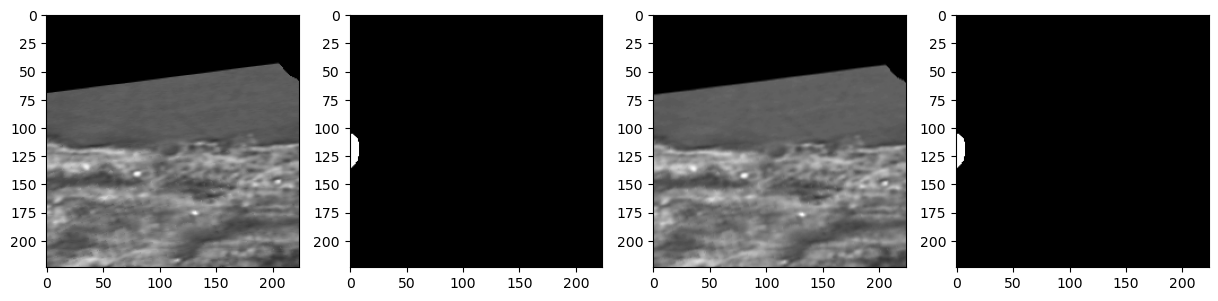

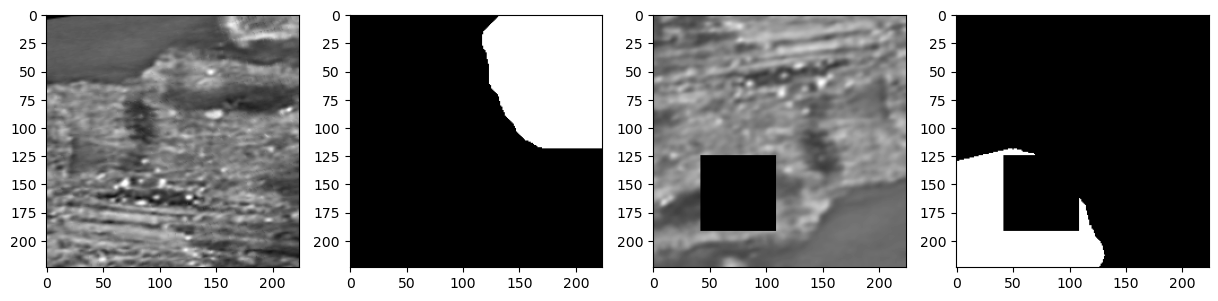

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b7


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501594322789131
th: 0.15, fbeta: 0.09502275242474542
th: 0.2, fbeta: 0.09502172381818047
th: 0.25, fbeta: 0.09497981076917905
th: 0.3, fbeta: 0.13867714497382755
th: 0.35, fbeta: 0.1467384013773027
th: 0.4, fbeta: 0.15130113885211383
th: 0.45, fbeta: 0.1541198144537786


best_th: 0.5, fbeta: 0.15588519171869314
Epoch 1 - avg_train_loss: 0.7312  avg_val_loss: 0.6123  time: 1269s
Epoch 1 - avgScore: 0.1559
Epoch 1 - Save Best Score: 0.1559 Model
Epoch 1 - Save Best Loss: 0.6123 Model


th: 0.5, fbeta: 0.15588519171869314


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09505864480075456
th: 0.15, fbeta: 0.09515440622695892
th: 0.2, fbeta: 0.1450098314580235
th: 0.25, fbeta: 0.15278041501738873
th: 0.3, fbeta: 0.1619115051528643
th: 0.35, fbeta: 0.17440955893057236
th: 0.4, fbeta: 0.20399754869496065


best_th: 0.5, fbeta: 0.33575743070190267
Epoch 2 - avg_train_loss: 0.5336  avg_val_loss: 0.4503  time: 1286s
Epoch 2 - avgScore: 0.3358
Epoch 2 - Save Best Score: 0.3358 Model
Epoch 2 - Save Best Loss: 0.4503 Model


th: 0.45, fbeta: 0.25813732822062285
th: 0.5, fbeta: 0.33575743070190267


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.28047342704026684
th: 0.15, fbeta: 0.38280159761789645
th: 0.2, fbeta: 0.46051451106455527
th: 0.25, fbeta: 0.5163640640928496
th: 0.3, fbeta: 0.5520996021836384
th: 0.35, fbeta: 0.5630570981875062
th: 0.4, fbeta: 0.5501155404974504
th: 0.45, fbeta: 0.5147220228584086


best_th: 0.35, fbeta: 0.5630570981875062
Epoch 3 - avg_train_loss: 0.2970  avg_val_loss: 0.1966  time: 1285s
Epoch 3 - avgScore: 0.5631
Epoch 3 - Save Best Score: 0.5631 Model
Epoch 3 - Save Best Loss: 0.1966 Model


th: 0.5, fbeta: 0.4499864125043676


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31057853243065353
th: 0.15, fbeta: 0.36392377142070625
th: 0.2, fbeta: 0.4062582635185656
th: 0.25, fbeta: 0.44434629486299954
th: 0.3, fbeta: 0.4775052548275345
th: 0.35, fbeta: 0.5068535506080577
th: 0.4, fbeta: 0.5342690233499201
th: 0.45, fbeta: 0.5543524528715926


best_th: 0.5, fbeta: 0.5607079100991971
Epoch 4 - avg_train_loss: 0.2402  avg_val_loss: 0.1917  time: 1290s
Epoch 4 - avgScore: 0.5607


th: 0.5, fbeta: 0.5607079100991971


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2716318521330266
th: 0.15, fbeta: 0.316209347762099
th: 0.2, fbeta: 0.35667550346661364
th: 0.25, fbeta: 0.3952632750488367
th: 0.3, fbeta: 0.4307260682788041
th: 0.35, fbeta: 0.46624845360806527
th: 0.4, fbeta: 0.4982596468283471
th: 0.45, fbeta: 0.5257375058658623


best_th: 0.5, fbeta: 0.5499344991816104
Epoch 5 - avg_train_loss: 0.2186  avg_val_loss: 0.2003  time: 1283s
Epoch 5 - avgScore: 0.5499


th: 0.5, fbeta: 0.5499344991816104


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28476460769403605
th: 0.15, fbeta: 0.3245208348480856
th: 0.2, fbeta: 0.35425428405627146
th: 0.25, fbeta: 0.3829589852592557
th: 0.3, fbeta: 0.4114908854404307
th: 0.35, fbeta: 0.44100266654682585
th: 0.4, fbeta: 0.4731216618205941
th: 0.45, fbeta: 0.5048663323289505


best_th: 0.5, fbeta: 0.5313347408520939
Epoch 6 - avg_train_loss: 0.2011  avg_val_loss: 0.2031  time: 1285s
Epoch 6 - avgScore: 0.5313


th: 0.5, fbeta: 0.5313347408520939


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.314055401385368
th: 0.15, fbeta: 0.35672828192277334
th: 0.2, fbeta: 0.3963428236230564
th: 0.25, fbeta: 0.4336319432435513
th: 0.3, fbeta: 0.46935445599338127
th: 0.35, fbeta: 0.5000022285496949
th: 0.4, fbeta: 0.5258025956585027
th: 0.45, fbeta: 0.5514795146731765


best_th: 0.5, fbeta: 0.5737922630238685
Epoch 7 - avg_train_loss: 0.1875  avg_val_loss: 0.1970  time: 1281s
Epoch 7 - avgScore: 0.5738
Epoch 7 - Save Best Score: 0.5738 Model
Epoch 7 - Save Best Loss: 0.1970 Model


th: 0.5, fbeta: 0.5737922630238685


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25200785554947214
th: 0.15, fbeta: 0.2797211644818506
th: 0.2, fbeta: 0.30566312269914403
th: 0.25, fbeta: 0.33225419248348675
th: 0.3, fbeta: 0.35864206219435046
th: 0.35, fbeta: 0.38482619262943674
th: 0.4, fbeta: 0.4126006119224166
th: 0.45, fbeta: 0.43750120149438276


best_th: 0.5, fbeta: 0.46089443033197447
Epoch 8 - avg_train_loss: 0.1727  avg_val_loss: 0.2438  time: 1286s
Epoch 8 - avgScore: 0.4609


th: 0.5, fbeta: 0.46089443033197447


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31695232127819506
th: 0.15, fbeta: 0.3658171400282127
th: 0.2, fbeta: 0.40555111998272264
th: 0.25, fbeta: 0.4403851172263601
th: 0.3, fbeta: 0.47315758668680286
th: 0.35, fbeta: 0.5010845040864533
th: 0.4, fbeta: 0.5238826849001461
th: 0.45, fbeta: 0.5456637334891916


best_th: 0.5, fbeta: 0.5660141481586825
Epoch 9 - avg_train_loss: 0.1610  avg_val_loss: 0.2039  time: 1282s
Epoch 9 - avgScore: 0.5660


th: 0.5, fbeta: 0.5660141481586825


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3007074237982783
th: 0.15, fbeta: 0.3450303468807862
th: 0.2, fbeta: 0.38280974934742285
th: 0.25, fbeta: 0.41579585298432137
th: 0.3, fbeta: 0.449492958146925
th: 0.35, fbeta: 0.4807646395746601
th: 0.4, fbeta: 0.5081634626728122
th: 0.45, fbeta: 0.5295955324542964


best_th: 0.5, fbeta: 0.5469829909989149
Epoch 10 - avg_train_loss: 0.1493  avg_val_loss: 0.2136  time: 1282s
Epoch 10 - avgScore: 0.5470


th: 0.5, fbeta: 0.5469829909989149


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2900484018600674
th: 0.15, fbeta: 0.3312197242744527
th: 0.2, fbeta: 0.368721492253204
th: 0.25, fbeta: 0.40474369377901287
th: 0.3, fbeta: 0.4407883775299296
th: 0.35, fbeta: 0.4730059773753653
th: 0.4, fbeta: 0.5010696695799484
th: 0.45, fbeta: 0.5262947395957441


best_th: 0.5, fbeta: 0.549430123082856
Epoch 11 - avg_train_loss: 0.1410  avg_val_loss: 0.2108  time: 1288s
Epoch 11 - avgScore: 0.5494


th: 0.5, fbeta: 0.549430123082856


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28733531090455156
th: 0.15, fbeta: 0.3248158401322375
th: 0.2, fbeta: 0.3593284170786799
th: 0.25, fbeta: 0.3903309394060893
th: 0.3, fbeta: 0.41883232118545644
th: 0.35, fbeta: 0.44583572388980736
th: 0.4, fbeta: 0.47073277957593634
th: 0.45, fbeta: 0.4943649159461268


best_th: 0.5, fbeta: 0.5171590395015186
Epoch 12 - avg_train_loss: 0.1327  avg_val_loss: 0.2256  time: 1282s
Epoch 12 - avgScore: 0.5172


th: 0.5, fbeta: 0.5171590395015186


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29758114947560377
th: 0.15, fbeta: 0.3361128995659357
th: 0.2, fbeta: 0.369341084363564
th: 0.25, fbeta: 0.399981882275045
th: 0.3, fbeta: 0.4274755921414835
th: 0.35, fbeta: 0.4537508470777874
th: 0.4, fbeta: 0.4784343504950228
th: 0.45, fbeta: 0.5005069945433024


best_th: 0.5, fbeta: 0.5211803389978553
Epoch 13 - avg_train_loss: 0.1260  avg_val_loss: 0.2320  time: 1286s
Epoch 13 - avgScore: 0.5212


th: 0.5, fbeta: 0.5211803389978553


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3096626555082887
th: 0.15, fbeta: 0.34663619007719915
th: 0.2, fbeta: 0.3816456998420934
th: 0.25, fbeta: 0.4130830708048807
th: 0.3, fbeta: 0.4431278766546936
th: 0.35, fbeta: 0.47205060890895484
th: 0.4, fbeta: 0.4985086007406068
th: 0.45, fbeta: 0.5210647519176225


best_th: 0.5, fbeta: 0.5397266373190504
Epoch 14 - avg_train_loss: 0.1217  avg_val_loss: 0.2261  time: 1285s
Epoch 14 - avgScore: 0.5397


th: 0.5, fbeta: 0.5397266373190504


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30704457922615486
th: 0.15, fbeta: 0.34400768102484924
th: 0.2, fbeta: 0.37697487223591236
th: 0.25, fbeta: 0.4058958702724574
th: 0.3, fbeta: 0.4349323614447475
th: 0.35, fbeta: 0.4637202066632836
th: 0.4, fbeta: 0.48933122524451383
th: 0.45, fbeta: 0.5103369841538019


best_th: 0.5, fbeta: 0.5288490769467192
Epoch 15 - avg_train_loss: 0.1179  avg_val_loss: 0.2315  time: 1284s
Epoch 15 - avgScore: 0.5288


th: 0.5, fbeta: 0.5288490769467192


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.314055401385368
th: 0.15, fbeta: 0.35672828192277334
th: 0.2, fbeta: 0.3963428236230564
th: 0.25, fbeta: 0.4336319432435513
th: 0.3, fbeta: 0.46935445599338127
th: 0.35, fbeta: 0.5000022285496949
th: 0.4, fbeta: 0.5258025956585027
th: 0.45, fbeta: 0.5514795146731765


best_th: 0.5, fbeta: 0.5737922630238685


th: 0.5, fbeta: 0.5737922630238685


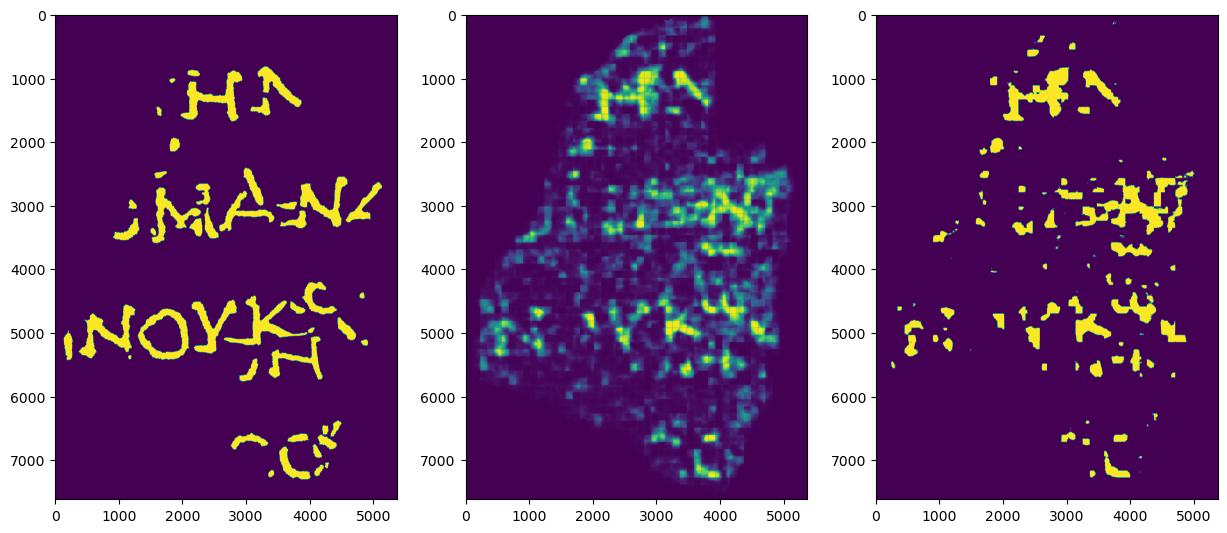

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([28243876.,  3368257.,  1843179.,  1303420.,  1004099.,   800455.,
          612978.,   483622.,   420246.,   387651.,   327836.,   292470.,
          276637.,   273182.,   257047.,   229035.,   188511.,   184329.,
          214545.,   232241.]),
 array([9.72208072e-05, 4.99171966e-02, 9.97371724e-02, 1.49557148e-01,
        1.99377124e-01, 2.49197100e-01, 2.99017076e-01, 3.48837051e-01,
        3.98657027e-01, 4.48477003e-01, 4.98296979e-01, 5.48116955e-01,
        5.97936931e-01, 6.47756906e-01, 6.97576882e-01, 7.47396858e-01,
        7.97216834e-01, 8.47036810e-01, 8.96856785e-01, 9.46676761e-01,
        9.96496737e-01]),
 <BarContainer object of 20 artists>)

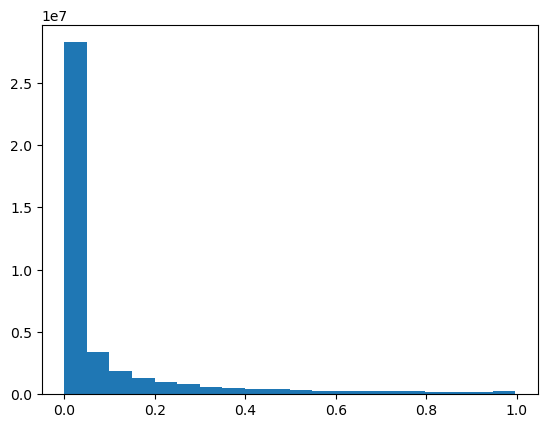

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000